<a href="https://colab.research.google.com/github/cagatayeskin/Data-Fitting-with-ANNs/blob/main/Polynomial_Data_with_Errors_on_Both_Axes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Fitting a Polynomial Model to Data with Errors in Both Coordinates***

To create a dataset, the model that we are going to use will be 

$$
y = a_{true} +b_{true}x + c_{true}x^2
$$

Then, we predict true parameters, and try to find best values of $a$, $b$ and $c$ for

$$
    y = a_{pred} + bx_{pred} + c_{pred}x^2
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.7.0


## Create data to fit a model

In [ ]:
N_test = 50 # number of data points
sigma_X = np.random.uniform(0.03, 0.07, N_test) # sample x coordinate sigmas from uniform distribution
sigma_Y = np.random.uniform(0.05, 0.10, N_test) # sample y coordinate sigmas from uniform distribution
noise_X = np.multiply(sigma_X, np.random.randn(N_test)) # error on x data (normally distributed)
noise_Y = np.multiply(sigma_Y, np.random.randn(N_test)) # error on y data (normally distributed)
 
# True parameters of the model which will be used to generate data
a_true = 2.7
b_true = 0.4
c_true = -1.3

X = np.linspace(0.1, 0.9, N_test) + noise_X  # observed X points
Y = a_true + b_true*(X-noise_X) + c_true*np.power((X-noise_X), 2)  # observed Y points


##ODR fit

In [ ]:
def func(beta, x):
  a, b, c = beta
  return a + b*x + c*x**2

data = RealData(X, Y, sigma_X, sigma_Y)
model = Model(func)

odr = ODR(data, model, [4.0, 4.0, -4.0])

odr.set_job(fit_type=0)
odr_output = odr.run()
print("Iteration 1:")
print("------------")
print("   stop reason:", odr_output.stopreason)
print("        params:", odr_output.beta)
print("          info:", odr_output.info)
print("       sd_beta:", odr_output.sd_beta)
print("sqrt(diag(cov):", np.sqrt(np.diag(odr_output.cov_beta)))

# if convergence is not reached, run again the algorithm
if odr_output.info != 1:
    print("\nRestart ODR till convergence is reached")
    i = 1
    while odr_output.info != 1 and i < 100:
        print("restart", i)
        odr_output = odr.restart()
        i += 1
    print("   stop reason:", odr_output.stopreason)
    print("        params:", odr_output.beta)
    print("          info:", odr_output.info)
    print("       sd_beta:", odr_output.sd_beta)
    print("sqrt(diag(cov):", np.sqrt(np.diag(odr_output.cov_beta)))

# Print the results and compare to least square
a_odr, b_odr, c_odr = odr_output.beta

Iteration 1:
------------
   stop reason: ['Sum of squares convergence']
        params: [ 2.69049463  0.43125606 -1.25985531]
          info: 1
       sd_beta: [0.02590324 0.11463662 0.1125484 ]
sqrt(diag(cov): [0.0564751  0.24993449 0.2453817 ]


## Plot data with ODR fit

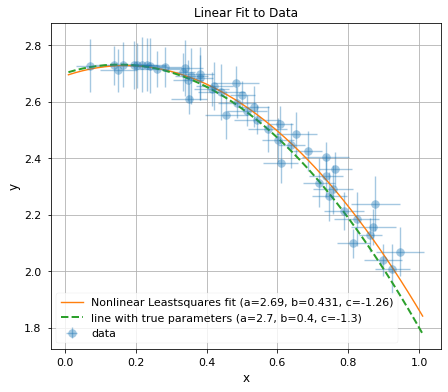

In [ ]:
# Create a figure
fig = plt.figure(figsize=(7, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=8.5, alpha=0.5)
plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=8.5, alpha=0.4) # error bars show SD

x_plot = np.linspace(0.01, 1.01, N_test)

y_ODR_fit = a_odr + b_odr*x_plot + c_odr*np.power(x_plot,2)
# Plotting Nonlinear Leastquares fit
plt.plot(x_plot, y_ODR_fit, label=('Nonlinear Leastsquares fit (a=' + str(np.round(a_odr, 3)) +
                                                            ', b=' + str(np.round(b_odr, 3)) + ', c=' + str(np.round(c_odr, 3)) +')') )

# Plotting the line with true parameters
y_true_plot = a_true + b_true*x_plot + c_true*np.power(x_plot, 2)
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ', c=' + str(c_true) + ')'))
# Plot specs
plt.tick_params(labelsize=11)
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.title('Linear Fit to Data', fontsize = 12)
plt.legend(fontsize = 11)
plt.grid()

# **Fitting a Model to Data with ANN**

## Define the ANN and its architecture

In [ ]:
model = keras.Sequential([
    layers.InputLayer(input_shape = (None, 4)),
    layers.LSTM(32, activation = 'tanh', return_sequences=True),
    layers.LSTM(16, activation = 'tanh'),
    layers.Dense(3),
])

model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(0.001))

##Download the trained model weights

In [ ]:
!wget https://drive.google.com/uc?id=1UtLipapo_TAvpNTepZgTk33aBpz_Vcn4&export=download 
model.load_weights('uc?id=1UtLipapo_TAvpNTepZgTk33aBpz_Vcn4')

--2021-11-15 12:32:51--  https://drive.google.com/uc?id=1UtLipapo_TAvpNTepZgTk33aBpz_Vcn4
Resolving drive.google.com (drive.google.com)... 209.85.147.101, 209.85.147.138, 209.85.147.113, ...
Connecting to drive.google.com (drive.google.com)|209.85.147.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ah6puonlgcmmp3ahi5kaegidulmfoj6r/1636979550000/06440322669498725628/*/1UtLipapo_TAvpNTepZgTk33aBpz_Vcn4 [following]
--2021-11-15 12:32:51--  https://doc-0o-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ah6puonlgcmmp3ahi5kaegidulmfoj6r/1636979550000/06440322669498725628/*/1UtLipapo_TAvpNTepZgTk33aBpz_Vcn4
Resolving doc-0o-9s-docs.googleusercontent.com (doc-0o-9s-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to doc-0o-9s-docs.googleusercontent.com (doc-0o-9s-docs.googleusercontent.com)|142.2

##Training (if you downloaded the weights, you can skip)

### Create training and validation datasets

In [ ]:
J = 100000 # number of training models

a_train = np.linspace(-4.0, 4.0, J)
b_train = np.linspace(-4.0, 4.0, J)
c_train = np.linspace(-4.0, 4.0, J)

# Shuffling the arrays to get random a and b pairs
np.random.shuffle(a_train)
np.random.shuffle(b_train)
np.random.shuffle(c_train)

def data_set(N, a, b, c):
  sigma_x = np.random.uniform(0.03, 0.07, N) # sample x coordinate sigmas from uniform distribution
  sigma_y = np.random.uniform(0.05, 0.10, N) # sample y coordinate sigmas from uniform distribution
  noise_x = np.multiply(sigma_x, np.random.randn(N)) # error on x data (normally distributed)
  noise_y = np.multiply(sigma_y, np.random.randn(N)) # error on y data (normally distributed) 
  x = np.linspace(0.1, 0.9, N) + noise_x
  y = a + b * (x-noise_x) + c * np.power((x-noise_x), 2) + noise_y
  training_features = np.zeros((N, 4))
  for i in range(N):
    for k in range(1):
      training_features[i,k] = x[i]
      training_features[i,k+1] = y[i]
      training_features[i,k+2] = sigma_x[i]
      training_features[i,k+3] = sigma_y[i]
  return(training_features)

In [ ]:
training_data = []
training_labels = np.zeros((J,3))

for j in range(J):
  N = np.random.randint(10,100)
  training_data.append(data_set(N, a_train[j], b_train[j], c_train[j]))
  training_labels[j,0] = a_train[j]
  training_labels[j,1] = b_train[j]
  training_labels[j,2] = c_train[j]

In [ ]:
# Manually split dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.20)
train_features = tf.ragged.constant(train_features)
val_features = tf.ragged.constant(val_features)

###Training process

In [ ]:
%%time
history = model.fit(
    train_features, train_labels,
    validation_data = (val_features, val_labels),
    verbose=1, epochs=50)

Epoch 1/50
2500/2500 [==============================] - 225s 89ms/step - loss: 1.9804 - val_loss: 1.4990
Epoch 2/50
2500/2500 [==============================] - 224s 89ms/step - loss: 0.8913 - val_loss: 0.3555
Epoch 3/50
2500/2500 [==============================] - 224s 89ms/step - loss: 0.2100 - val_loss: 0.4068
Epoch 4/50
2500/2500 [==============================] - 223s 89ms/step - loss: 0.2391 - val_loss: 0.1150
Epoch 5/50
2500/2500 [==============================] - 224s 90ms/step - loss: 0.1097 - val_loss: 0.0833
Epoch 6/50
2500/2500 [==============================] - 224s 90ms/step - loss: 0.0894 - val_loss: 0.0764
Epoch 7/50
2500/2500 [==============================] - 224s 89ms/step - loss: 0.0845 - val_loss: 0.0852
Epoch 8/50
2500/2500 [==============================] - 223s 89ms/step - loss: 0.0788 - val_loss: 0.0839
Epoch 9/50
2500/2500 [==============================] - 223s 89ms/step - loss: 0.0732 - val_loss: 0.0623
Epoch 10/50
2500/2500 [==============================] 

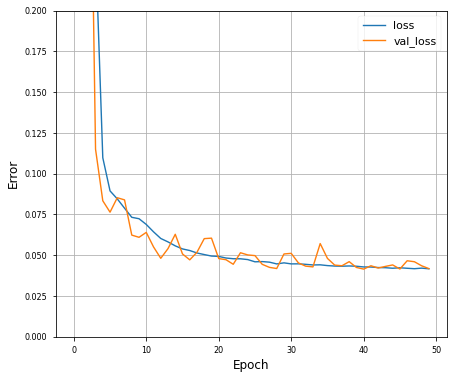

In [ ]:
def plot_loss(history):
    fig = plt.figure(figsize=(7, 6))
    plt.style.use('seaborn-paper')
    plt.rc('font', family='sans-serif')  
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.2])
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Error', fontsize = 12)
    plt.legend()
    plt.grid(True)
    plt.legend(fontsize = 11)
plot_loss(history)

## Make predictions

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4736      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 7,923
Trainable params: 7,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Now create the appropriate tensor for our data which we need to fit the model
main = np.zeros((1, N_test, 4))

for i in range(N_test):
    main[0,i,0] = X[i]
    main[0,i,1] = Y[i]
    main[0,i,2] = sigma_X[i]
    main[0,i,3] = sigma_Y[i]

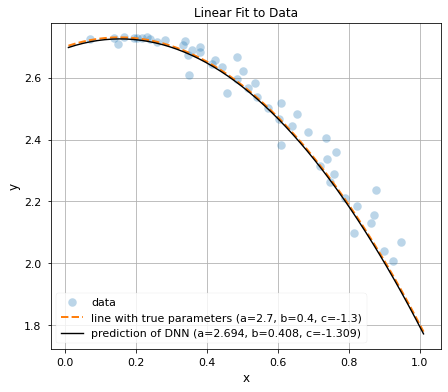

In [ ]:
# Create a figure
fig = plt.figure(figsize=(7, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
plt.plot(X, Y, 'o', label='data', ms=8.5, alpha=0.3)
#plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=8.5, alpha=0.8) # error bars show SD

# Plotting the line with true parameters
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ', c=' + str(c_true) + ')'))

# Make predictions
a_fit_DNN = model.predict(main)[0,0]
b_fit_DNN = model.predict(main)[0,1]
c_fit_DNN = model.predict(main)[0,2]

# Plotting predictions of DNN
y_DNN = a_fit_DNN + b_fit_DNN*x_plot + c_fit_DNN * np.power(x_plot,2)
plt.plot(x_plot, y_DNN, label = ('prediction of DNN (a=' + str(np.round(a_fit_DNN, 3)) +
                                 ', b=' + str(np.round(b_fit_DNN, 3)) + ', c=' + str(np.round(c_fit_DNN, 3)) + ')'), color = 'black')

# Plot specs
plt.tick_params(labelsize=11)
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.title('Linear Fit to Data', fontsize = 12)
plt.legend(fontsize = 11)
plt.grid()

### Plotting triple figures

In [ ]:
true_params = np.zeros([3,3])

true_params[0,0] = 3.7
true_params[0,1] = -1.4
true_params[0,2] = 1.9

true_params[1,0] = -1.6
true_params[1,1] = 2.8
true_params[1,2] = -3.0

true_params[2,0] = 3.2
true_params[2,1] = 0.3
true_params[2,2] = 1.6

point_nums = [80, 45, 25]

ODR_inits = [[1, -1, 1], [-1,2,-1], [1,1,1]]

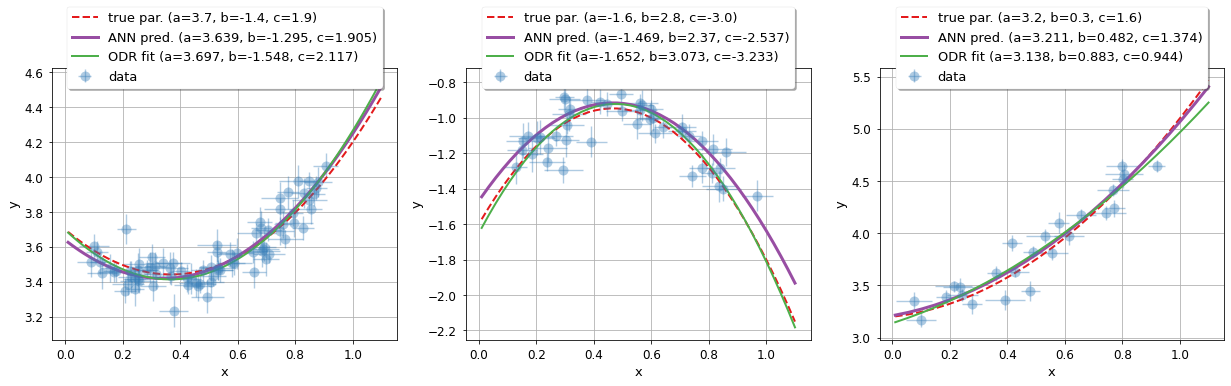

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (21,5))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

def triple(a, b, c, num, N):
  sigma_X = np.random.uniform(0.03, 0.07, N) # sample x coordinate sigmas from uniform distribution
  sigma_Y = np.random.uniform(0.05, 0.10, N) # sample y coordinate sigmas from uniform distribution
  noise_X = np.multiply(sigma_X, np.random.randn(N)) # error on x data (normally distributed)
  noise_Y = np.multiply(sigma_Y, np.random.randn(N)) # error on y data (normally distributed)
  X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
  Y = c*np.power((X-noise_X),2) + b*(X-noise_X) + a + noise_Y # observed Y points

  def odr_fit():
    def func(beta, x):
      a, b, c = beta
      return a + b*x + c*x**2

    data = RealData(X, Y, sigma_X, sigma_Y)
    model = Model(func)

    odr = ODR(data, model, ODR_inits[num])

    odr.set_job(fit_type=0)
    odr_output = odr.run()

    if odr_output.info != 1:
        print("\nRestart ODR till convergence is reached")
        j = 1
        while odr_output.info != 1 and j < 100:
            print("restart", j)
            odr_output = odr.restart()
            j += 1

    a_odr, b_odr, c_odr = odr_output.beta
    return(a_odr, b_odr, c_odr)

  data = np.zeros((1, N, 4))
  for i in range(N):
    data[0,i,0] = X[i]
    data[0,i,1] = Y[i]
    data[0,i,2] = sigma_X[i]
    data[0,i,3] = sigma_Y[i]

  x_plot = np.linspace(0.01, 1.1, N)
  y_true_plot = c*np.power(x_plot, 2) + b*x_plot + a

  odr_params = odr_fit()

  y_ODR_fit = odr_params[0]+ odr_params[1]*x_plot + odr_params[2]*np.power(x_plot,2)

  a_ANN = model.predict(data)[0,0]
  b_ANN = model.predict(data)[0,1]
  c_ANN = model.predict(data)[0,2]
  y_ANN = a_ANN + b_ANN*x_plot + c_ANN*np.power(x_plot, 2)

  axs[num].errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=10.0, alpha=0.4, color = '#377eb8') # error bars show SD
  axs[num].plot(x_plot, y_true_plot, '--', linewidth = 2, label=('true par. (a=' + str(a) +
                                                                       ', b=' + str(b) + ', c=' + str(c) + ')' ), color = '#e41a1c')
  axs[num].plot(x_plot, y_ANN, linewidth = 3, label = ('ANN pred. (a=' + str(np.round(a_ANN, 3)) +
                                                          ', b=' + str(np.round(b_ANN, 3)) + ', c=' + str(np.round(c_ANN, 3)) + ')'), color = '#984ea3')
  
  axs[num].plot(x_plot, y_ODR_fit, linewidth = 2, label = ('ODR fit (a=' + str(np.round(odr_params[0], 3)) +
                                                           ', b=' + str(np.round(odr_params[1], 3)) +
                                                           ', c=' + str(np.round(odr_params[2], 3)) + ')'), color = '#4daf4a')
  
  axs[num].set_xlabel('x', fontsize = 13)
  axs[num].set_ylabel('y', fontsize = 13)

  axs[num].tick_params(labelsize=12)
  axs[num].legend(fontsize = 13, ncol=1, shadow=True, fancybox=True, loc='lower center', bbox_to_anchor=(0.5, 0.9))
  axs[num].grid()
  return()

for i in range(3):
  n = point_nums[i]
  triple(true_params[i,0], true_params[i,1], true_params[i,2], i, n)



## Calculate parameter variances

Create lots of datasets having the same true parameters but with different $x$, $y$ and error values. Then make predictions for each one. After that, look at the distributions of these predictions.

In [ ]:
def quality_data(N):
    sigma_X = np.random.uniform(0.03, 0.07, N) # sample x coordinate sigmas from uniform distribution
    sigma_Y = np.random.uniform(0.05, 0.10, N) # sample y coordinate sigmas from uniform distribution
    noise_X = np.multiply(sigma_X, np.random.randn(N)) # error on x data (normally distributed)
    noise_Y = np.multiply(sigma_Y, np.random.randn(N)) # error on y data (normally distributed)
 
    # True parameters of the model which will be used to generate data
    a_true = a_fit_DNN
    b_true = b_fit_DNN
    c_true = c_fit_DNN

    X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
    Y = a_true + b_true*(X-noise_X) + c_true*np.power(X-noise_X, 2) + noise_Y
    main_qual = np.zeros((1, N, 4))

    for i in range(N):
        main_qual[0,i,0] = X[i]
        main_qual[0,i,1] = Y[i]
        main_qual[0,i,2] = sigma_X[i]
        main_qual[0,i,3] = sigma_Y[i]
    return main_qual

a_qual = []
b_qual = []
c_qual = []

for i in range(1000):
    n = np.random.randint(10,100)
    pred = model.predict(quality_data(n))
    a_qual.append(pred[0,0])
    b_qual.append(pred[0,1])
    c_qual.append(pred[0,2])

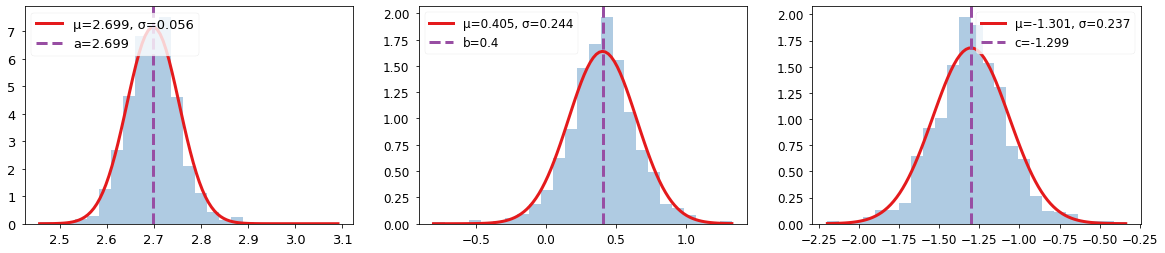

In [ ]:
import scipy
from scipy import stats

fig, axs = plt.subplots(1, 3, figsize=(20,4))

_, bins_a, _ = axs[0].hist(a_qual, 25, density = True, alpha=0.4, color = '#377eb8')
sigma_a = np.std(a_qual)
mu_a = np.mean(a_qual)
a_x_axis_gauss = np.linspace(bins_a[0], bins_a[-1], 100)
best_fit_line_a = scipy.stats.norm.pdf(a_x_axis_gauss, mu_a, sigma_a)
axs[0].plot(a_x_axis_gauss, best_fit_line_a, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_a, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_a, 3))), linewidth = 3.0)
axs[0].axvline(mu_a, linestyle="--", color = '#984ea3', linewidth = 3.0, 
            label = 'a=' + str(np.round(a_fit_DNN, 3)))
axs[0].legend(fontsize = 13, loc = 'upper left')
axs[0].tick_params(labelsize = 13)

_, bins_b, _ = axs[1].hist(b_qual, 25, density=True, alpha=0.4, color = '#377eb8')
sigma_b = np.std(b_qual)
mu_b = np.mean(b_qual)
b_x_axis_gauss = np.linspace(bins_b[0], bins_b[-1], 100)
best_fit_line_b = scipy.stats.norm.pdf(b_x_axis_gauss, mu_b, sigma_b)
axs[1].plot(b_x_axis_gauss, best_fit_line_b, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_b, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_b, 3))), linewidth = 3.0)
axs[1].axvline(mu_b, linestyle="--", 
            color = '#984ea3', linewidth = 3.0, label = 'b=' + str(np.round(b_fit_DNN, 3)))
axs[1].legend(fontsize = 12)
axs[1].tick_params(labelsize=12)

_, bins_c, _ = axs[2].hist(c_qual, 25, density=True, alpha=0.4, color = '#377eb8')
sigma_c = np.std(c_qual)
mu_c = np.mean(c_qual)
c_x_axis_gauss = np.linspace(bins_c[0], bins_c[-1], 100)
best_fit_line_c = scipy.stats.norm.pdf(c_x_axis_gauss, mu_c, sigma_c)
axs[2].plot(c_x_axis_gauss, best_fit_line_c, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_c, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_c, 3))), linewidth = 3.0)
axs[2].axvline(mu_c, linestyle="--", 
            color='#984ea3', linewidth = 3.0, label = 'c=' + str(np.round(c_fit_DNN, 3)))
axs[2].legend(fontsize = 12, loc = 'upper right')
axs[2].tick_params(labelsize=12)

plt.show()